<a href="https://colab.research.google.com/github/Vikash9071/Customer-Sentiment-Analysis/blob/main/Customer_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# ===============================
# Customer Sentiment Analysis - Colab Version
# Word2Vec + Random Forest + Generative AI
# ===============================

# Step 1: Install missing packages in Colab
#!pip install gensim wordcloud transformers

# Step 2: Import Libraries
import pandas as pd
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from gensim.models import Word2Vec
from wordcloud import WordCloud
from transformers import pipeline

In [13]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Step 3: Load Dataset
# ===============================
from google.colab import files
uploaded = files.upload()   # Upload amazon review.csv

df = pd.read_csv("/content/amazon review.csv")

# Keep only reviewText and overall rating
df = df[['reviewText','overall']].dropna()

# Convert rating -> sentiment label
def rating_to_sentiment(rating):
    if rating >= 4:
        return 1   # Positive
    elif rating <= 2:
        return 0   # Negative
    else:
        return None  # Neutral -> drop
df['label'] = df['overall'].apply(rating_to_sentiment)

# Drop neutral rows
df = df.dropna(subset=['label'])

print("Dataset shape:", df.shape)
print(df.head())


Saving amazon review.csv to amazon review (1).csv
Dataset shape: (4772, 3)
                                          reviewText  overall  label
0                                         No issues.        4    1.0
1  Purchased this for my device, it worked as adv...        5    1.0
2  it works as expected. I should have sprung for...        4    1.0
3  This think has worked out great.Had a diff. br...        5    1.0
4  Bought it with Retail Packaging, arrived legit...        5    1.0


In [5]:
# Step 4: Preprocess Text
# ===============================
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = [w for w in text.split() if w not in stop_words]
    return words

df['tokens'] = df['reviewText'].apply(preprocess)

/tmp/ipython-input-1011421476.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set2')


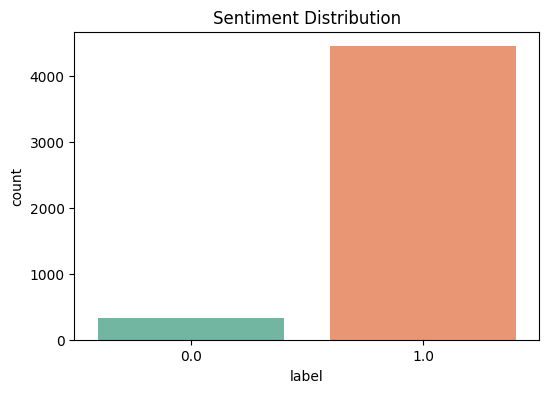

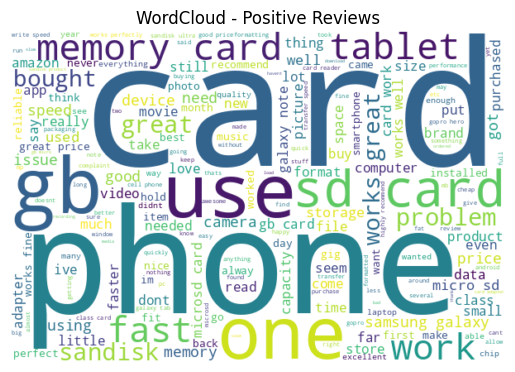

In [6]:
# Step 5: EDA - Sentiment Distribution
# ===============================
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette='Set2')
plt.title("Sentiment Distribution")
plt.show()

# WordCloud for positive reviews
positive_text = " ".join([" ".join(words) for words in df[df['label']==1]['tokens']])
wc = WordCloud(width=600, height=400, background_color="white").generate(positive_text)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Positive Reviews")
plt.show()

In [7]:
# Step 6: Word2Vec Embeddings
# ===============================
w2v_model = Word2Vec(sentences=df['tokens'], vector_size=50, window=5, min_count=2, workers=4)

def get_vector(tokens):
    vec = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
    return np.mean(vec, axis=0) if len(vec)>0 else np.zeros(50)

df['vector'] = df['tokens'].apply(get_vector)


In [8]:
# Step 7: Train-Test Split
# ===============================
X = list(df['vector'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Model Accuracy: 0.9361256544502617

Classification Report:
               precision    recall  f1-score   support

         0.0       0.62      0.20      0.30        66
         1.0       0.94      0.99      0.97       889

    accuracy                           0.94       955
   macro avg       0.78      0.59      0.63       955
weighted avg       0.92      0.94      0.92       955



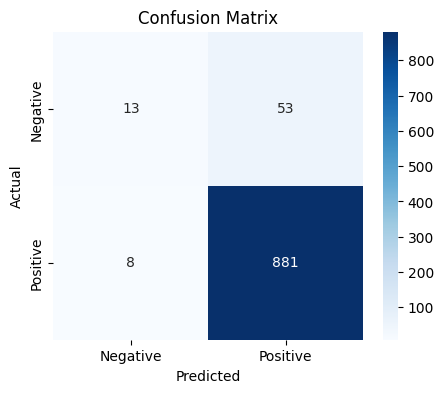

In [9]:
# Step 8: Train Random Forest
# ===============================
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative","Positive"], yticklabels=["Negative","Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [10]:
# Step 9: Generative AI for Insights
# ===============================
gen_ai = pipeline("text-generation", model="distilgpt2")

def explain_sentiment(review, prediction):
    label = "Positive" if prediction==1 else "Negative"
    prompt = f"Review: {review}\nPredicted Sentiment: {label}\nExplain briefly why the review has this sentiment:"
    result = gen_ai(prompt, max_length=50, num_return_sequences=1)
    return result[0]['generated_text']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [11]:
# Demo
sample_review = "The product quality is amazing and delivery was quick."
sample_tokens = preprocess(sample_review)
sample_vec = [get_vector(sample_tokens)]
prediction = clf.predict(sample_vec)[0]

print("\nSample Review:", sample_review)
print("Predicted Sentiment:", "Positive" if prediction==1 else "Negative")
print("Generative AI Insight:", explain_sentiment(sample_review, prediction))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



Sample Review: The product quality is amazing and delivery was quick.
Predicted Sentiment: Positive
Generative AI Insight: Review: The product quality is amazing and delivery was quick.
Predicted Sentiment: Positive
Explain briefly why the review has this sentiment:
If we can get people to buy a new product on the market, I think that's a good thing!
The review is very encouraging. It is a product that will be a great purchase for our new customers and I am very happy to see the result!
The product is very well received and is great value.
The reviews are very pleasant, and are very useful for our new customers.
I don't need to be in a negative mood to say that I am disappointed.
I don't need to be in a negative mood to say that I am disappointed. The reviews are very pleasant, and are very useful for our new customers.
I don't need to be in a negative mood to say that I am disappointed.
I don't need to be in a negative mood to say that I am disappointed.
The reviews are very pleasant